# Important note

1. This notebook is built upon this quickstarter by https://www.kaggle.com/code/ambrosm/msci-multiome-quickstart

2. It reads the Multime traning data in sparse mode,from this dataset: https://www.kaggle.com/datasets/sbunzini/open-problems-msci-multiome-sparse-matrices

3. During CV this NB reads the whole training dataset,in four chunks. It takes 33 minutes to complete.

4. It uses truncatedSVD for reducing the number of features, to 512.

5. The model is Ridge. I tried LinearRegression and KNN  (very fast) and DecisionTrees, LinearSVD (dual=False),LGBM and CatBoost (excruciatingly slow).

6. The CV is about 0.658, which is not an improvement. 

I hope this helps.

# Multiome Quickstart

This notebook shows how to cross-validate a baseline model and create a submission for the Multiome part of the *Multimodal Single-Cell Integration* competition without running out of memory.

It does not show the EDA - see the separate notebook [MSCI EDA which makes sense ⭐️⭐️⭐️⭐️⭐️](https://www.kaggle.com/ambrosm/msci-eda-which-makes-sense).

The baseline model for the other part of the competition (CITEseq) is [here](https://www.kaggle.com/ambrosm/msci-citeseq-quickstart).

In [1]:
import os, gc, pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from colorama import Fore, Back, Style
from matplotlib.ticker import MaxNLocator
import tensorflow as tf
import scipy.sparse as sps
from scipy.sparse.linalg import lsqr
import math

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model
from keras import backend as K
from tensorflow.keras.layers import Dropout,Dense, Input, Concatenate
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
from sklearn.decomposition import TruncatedSVD
#from sklearn.preprocessing import StandardScaler, scale
#from sklearn.decomposition import PCA
#from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Ridge, LinearRegression, Lasso, HuberRegressor
from sklearn.metrics import mean_squared_error

#import lightgbm as lgb
#import catboost as cb
#from catboost import CatBoost,CatBoostRegressor, Pool
#from sklearn.multioutput import MultiOutputRegressor

DATA_DIR = "./data/"
FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")

FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5")
FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5")
FP_CITE_TEST_INPUTS = os.path.join(DATA_DIR,"test_cite_inputs.h5")

FP_MULTIOME_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_multi_inputs.h5")
FP_MULTIOME_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_multi_targets.h5")
FP_MULTIOME_TEST_INPUTS = os.path.join(DATA_DIR,"test_multi_inputs.h5")

FP_SUBMISSION = os.path.join(DATA_DIR,"sample_submission.csv")
FP_EVALUATION_IDS = os.path.join(DATA_DIR,"evaluation_ids.csv")

# The scoring function

It is a slight modification of the original scoring function. No averages.

In [2]:
def correlation_score(y_true, y_pred):
    """Scores the predictions according to the competition rules. 
    
    It is assumed that the predictions are not constant.
    
    Returns the average of each sample's Pearson correlation coefficient"""
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    if y_true.shape != y_pred.shape: raise ValueError("Shapes are different.")
    corrsum = 0
    for i in range(len(y_true)):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
   
    return corrsum, len(y_true)
    #return corrsum / len(y_true)

    
def negative_correlation_loss(y_true, y_pred):
    """Negative correlation loss function for Keras
    
    NO Precondition:
    y_true.mean(axis=1) == 0
    y_true.std(axis=1) == 1
    
    Returns:
    -1 = perfect positive correlation
    1 = totally negative correlation
    """

    my = K.mean(tf.convert_to_tensor(y_pred), axis=1)
    my_true = K.mean(tf.convert_to_tensor(y_true), axis=1)
    my = tf.tile(tf.expand_dims(my, axis=1), (1, K.shape(y_pred)[1]))
    my_true = tf.tile(tf.expand_dims(my_true, axis=1), (1, K.shape(y_true)[1]))
    ym = y_pred - my
    ym_true = y_true - my_true
    r_num = K.sum(tf.multiply(ym_true, ym), axis=1)
    r_den = tf.sqrt(K.sum(K.square(ym), axis=1) * K.sum(K.square(ym_true), axis=1))
    r = tf.reduce_mean(r_num / r_den)
    return - r


# Preprocessing and cross-validation

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
cite_train_x_df = pd.read_hdf(FP_CITE_TRAIN_INPUTS)

In [5]:
cite_train_y_df = pd.read_hdf(FP_CITE_TRAIN_TARGETS)

In [6]:
cite_train_x_raw = cite_train_x_df.values

In [7]:
cite_train_y_raw = cite_train_y_df.values

In [8]:
cite_train_y_raw.shape

(70988, 140)

In [9]:
cite_train_x_raw.shape

(70988, 22050)

In [10]:
results_df = pd.read_csv('cite_train_corr.csv')

In [11]:
results_df

,Unnamed: 0,y_col,x_col,pcorr
0,0,0,0,0.000912
1,1,0,1,0.002799
2,2,0,2,0.056300
3,3,0,3,0.003715
4,4,0,4,0.003666
...,...,...,...,...
3086995,3086995,139,22045,0.011796
3086996,3086996,139,22046,0.031392
3086997,3086997,139,22047,0.051826
3086998,3086998,139,22048,0.051478


In [12]:
results_df = results_df[results_df['pcorr'].notna()]

In [13]:
results_df

,Unnamed: 0,y_col,x_col,pcorr
0,0,0,0,0.000912
1,1,0,1,0.002799
2,2,0,2,0.056300
3,3,0,3,0.003715
4,4,0,4,0.003666
...,...,...,...,...
3086995,3086995,139,22045,0.011796
3086996,3086996,139,22046,0.031392
3086997,3086997,139,22047,0.051826
3086998,3086998,139,22048,0.051478


In [15]:
top100 = results_df.sort_values(['pcorr'],ascending=False).groupby('y_col').head(200)

In [16]:
bot100 = results_df.sort_values(['pcorr'],ascending=True).groupby('y_col').head(200)

In [17]:
top100_idx = top100['x_col'].drop_duplicates().values

In [18]:
bot100_idx = bot100['x_col'].drop_duplicates().values

In [19]:
len(top100_idx)

2668

In [20]:
len(bot100_idx)

2222

In [21]:
p2_idx = results_df[results_df['pcorr']>0.15]['x_col'].drop_duplicates().values

In [22]:
mp2_idx = results_df[results_df['pcorr']<-0.15]['x_col'].drop_duplicates().values

In [23]:
len(p2_idx)

3445

In [24]:
len(mp2_idx)

840

In [25]:
use_idx = list(set(list(top100_idx) + list(bot100_idx) + list(p2_idx) + list(mp2_idx)))

In [26]:
len(use_idx)

4651

In [27]:
cite_train_x_raw = cite_train_x_raw[:,use_idx]

In [28]:
cite_train_x_raw.shape

(70988, 4651)

### Start training

In [29]:
cell_df = pd.read_csv("df_cell.csv")

In [30]:
cell_df = cell_df[['cell_id','day','donor_index']]

In [31]:
cell_df.astype({'day':'float32','donor_index':'float32'})

,cell_id,day,donor_index
0,c2150f55becb,2.0,0.0
1,65b7edf8a4da,2.0,0.0
2,526647a698f8,2.0,0.0
3,ab8f207a3dec,2.0,0.0
4,08df3dcce25c,2.0,0.0
...,...,...,...
281523,96a60b026659,10.0,3.0
281524,d493e546991e,10.0,3.0
281525,05666c99aa48,10.0,3.0
281526,121f946642b5,10.0,3.0


In [32]:
cite_train_x_df.iloc[:,use_idx]

gene_id,ENSG00000200397_RF00019,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000128274_A4GALT,ENSG00000120675_DNAJC15,ENSG00000115977_AAK1,ENSG00000087884_AAMDC,ENSG00000205981_DNAJC19,ENSG00000127837_AAMP,ENSG00000105821_DNAJC2,...,ENSG00000185800_DMWD,ENSG00000165506_DNAAF2,ENSG00000167646_DNAAF3,ENSG00000164818_DNAAF5,ENSG00000185842_DNAH14,ENSG00000274008_RF00017,ENSG00000086061_DNAJA1,ENSG00000069345_DNAJA2,ENSG00000140403_DNAJA4,ENSG00000090520_DNAJB11
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,0.0,0.0,0.0,0.000000,4.774929,0.000000,4.090185,0.000000,4.774929,5.177577,...,0.000000,0.000000,0.0,4.090185,0.000000,0.0,6.154874,0.000000,0.000000,4.090185
d02759a80ba2,0.0,0.0,0.0,0.000000,5.126350,4.039545,4.723850,5.816524,5.126350,4.723850,...,0.000000,4.039545,0.0,0.000000,0.000000,0.0,5.634798,0.000000,0.000000,4.039545
c016c6b0efa5,0.0,0.0,0.0,3.847321,4.529743,0.000000,3.847321,4.931607,0.000000,3.847321,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,4.529743,4.529743,0.000000,0.000000
ba7f733a4f75,0.0,0.0,0.0,0.000000,5.487739,4.513782,3.436846,5.354798,4.798720,4.798720,...,0.000000,3.436846,0.0,3.436846,0.000000,0.0,5.487739,4.113780,0.000000,4.798720
fbcf2443ffb2,0.0,0.0,0.0,0.000000,4.597264,0.000000,4.597264,5.104050,0.000000,5.689135,...,3.518610,3.518610,0.0,0.000000,0.000000,0.0,6.380589,5.438786,0.000000,4.196826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650ee456f0f3,0.0,0.0,0.0,0.000000,5.774556,0.000000,4.397535,5.084510,4.397535,5.084510,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,5.084510,0.000000,0.000000,0.000000
cc506e7707f5,0.0,0.0,0.0,0.000000,5.067562,0.000000,0.000000,5.353669,0.000000,5.575866,...,0.000000,0.000000,0.0,0.000000,4.665241,0.0,6.044448,3.981467,0.000000,3.981467
a91f1b55a520,0.0,0.0,0.0,0.000000,5.407283,3.815622,0.000000,4.899442,3.815622,4.497696,...,3.815622,0.000000,0.0,0.000000,4.497696,0.0,5.407283,3.815622,3.815622,3.815622


In [33]:
cite_train_x_df = cite_train_x_df.iloc[:,use_idx].merge(cell_df, how='left',left_on='cell_id', right_on='cell_id').set_index('cell_id')

In [34]:
cite_train_x_raw = cite_train_x_df.values

In [35]:
cite_train_y_raw = cite_train_y_df.values

In [36]:
del cite_train_x_df,cite_train_y_df

In [37]:
gc.collect()

0

In [38]:
cite_train_y_raw.shape

(70988, 140)

In [39]:
cite_train_x_raw.shape

(70988, 4653)

In [40]:
lam = 0.00

class CorrelationLoss_new(tf.keras.losses.Loss):
    
    def call(self, y_true, y_pred):
        return negative_correlation_loss(y_true, y_pred) + lam * tf.keras.losses.MeanSquaredError()(y_true,y_pred)

In [41]:
class CorrelationLoss_pure(tf.keras.losses.Loss):
    
    def call(self, y_true, y_pred):
        return negative_correlation_loss(y_true, y_pred)

In [42]:
class CorrelationMetric(tf.keras.metrics.Mean):
    def __init__(self, name='correlation_metric', **kwargs):
        super(CorrelationMetric, self).__init__(name=name, **kwargs)
        self.correlation = self.add_weight(name='corr', initializer='zeros')
    def update_state(self, y_true, y_pred, **kwargs):
        corr =  - negative_correlation_loss(y_true, y_pred)/1996
        super().update_state(corr, **kwargs)
        self.correlation.assign_add(corr)
    def result(self):
        return self.correlation


In [43]:
class MultiomeSequence(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size=64):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return self.x.shape[0] // self.batch_size

    def __getitem__(self, idx):
        """
        Return the idx-th batch
        """

        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

In [44]:
class MultiomeSequence_test(tf.keras.utils.Sequence):

    def __init__(self, x_set, batch_size=64):
        self.x= x_set
        self.batch_size = batch_size

    def __len__(self):
        return self.x.shape[0] // self.batch_size

    def __getitem__(self, idx):
        """
        Return the idx-th batch
        """

        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x
        

## First go without any dropout, when validation and training have the same loss, turn on the dropout.

In [45]:
def my_model(input_size = 200, output_size = 200, middle_size = 100, layer_num = 4, init_dropout = 0.2, layer_dropout=0.2, activation = 'swish'):
    """Sequential neural network
    
    Returns a compiled instance of tensorflow.keras.models.Model.
    """

    inputs = Input(shape=(input_size, ))
    vip_inputs = tf.slice(inputs, [0, input_size - 2], [-1,2])
    
    inputs_dropout = Dropout(init_dropout)(inputs)
    
    
    layers = [inputs_dropout]
    for i in range(layer_num - 1):
        layers.append(Concatenate()([Dropout(layer_dropout)(Dense(middle_size-2, activation=activation)(layers[i])), vip_inputs]))
    last_layer = Dense(output_size)(layers[-1])

    regressor = Model(inputs, last_layer)
    
    return regressor

In [46]:
def my_model_2(input_size = 200, output_size = 200, middle_size = 100, layer_num = 4, init_dropout = 0.2, layer_dropout=0.2, activation = 'swish'):
    """Sequential neural network
    
    Returns a compiled instance of tensorflow.keras.models.Model.
    """

    inputs = Input(shape=(input_size, ))
    vip_inputs = tf.slice(inputs, [0, input_size - 2], [-1,2])
    
    inputs_dropout = Dropout(init_dropout)(inputs)
    
    
    layers = [inputs_dropout]
    for i in range(layer_num - 1):
        layers.append(Concatenate()([Dropout(layer_dropout-0.1*i)(Dense(middle_size-2, activation=activation)(layers[i])), vip_inputs]))
    last_layer = Dense(output_size)(layers[-1])

    regressor = Model(inputs, last_layer)
    
    return regressor

In [47]:
%%time
# Cross-validation
# multi_train_x = multi_train_x_raw
# multi_train_y = multi_train_y_raw
gc.collect()
K.clear_session()
model = None
model = my_model_2(cite_train_x_raw.shape[1], cite_train_y_raw.shape[1], 4096, 4, init_dropout=0.2, layer_dropout=0.7, activation='selu')
print(model.summary())
model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),loss = CorrelationLoss_new())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4653)]       0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 4653)         0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 4094)         19053476    dropout[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4094)         0           dense[0][0]                      
______________________________________________________________________________________________

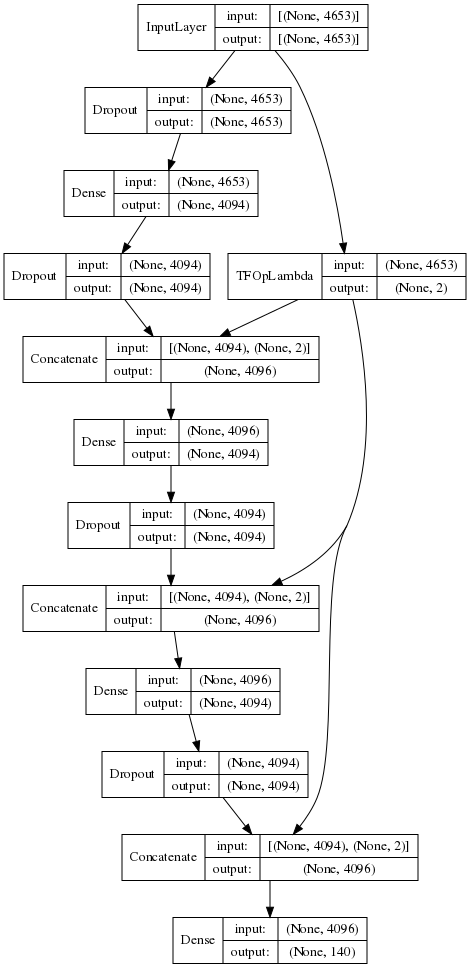

In [48]:
display(plot_model(model, show_layer_names=False, show_shapes=True, dpi=72))

In [49]:
# model.load_weights("./model/cite_2048_3_p8_goodloss_test")

In [54]:
kf = KFold(n_splits = 8, shuffle = True, random_state=23)
score_list = []
b_size = 4096
idx_tr, idx_va = next(kf.split(cite_train_x_raw))

In [55]:
cite_train_x_raw.shape

(70988, 4653)

In [56]:
training_generator = MultiomeSequence(cite_train_x_raw[idx_tr], cite_train_y_raw[idx_tr], batch_size=b_size)
validation_generator = MultiomeSequence(cite_train_x_raw[idx_va], cite_train_y_raw[idx_va], batch_size=b_size)
retraining_generator = MultiomeSequence(cite_train_x_raw, cite_train_y_raw, batch_size=b_size)

In [57]:
gc.collect()

0

### Next time try "swish" as activation function.

In [58]:
# checkpoint_filepath = './cite_v31/checkpoint{epoch:02d}'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='loss', save_freq=1996*11, save_best_only=False, mode='auto')

In [59]:
# epoc = 100
# train_hist = model.fit(retraining_generator, validation_data=validation_generator, batch_size=b_size,epochs=epoc, verbose=1,validation_freq=5, callbacks=[model_checkpoint_callback])

In [60]:
epoc = 1000
train_hist = model.fit(training_generator, validation_data=validation_generator, batch_size=b_size,epochs=epoc, verbose=1,validation_freq=5)

Epoch 1/1000
15/15 [==============================] - 4s 189ms/step - loss: -0.7320
Epoch 2/1000
15/15 [==============================] - 3s 187ms/step - loss: -0.8002
Epoch 3/1000
15/15 [==============================] - 3s 188ms/step - loss: -0.8021
Epoch 4/1000
15/15 [==============================] - 3s 194ms/step - loss: -0.8021
Epoch 5/1000
15/15 [==============================] - 3s 213ms/step - loss: -0.8027 - val_loss: -0.8104
Epoch 6/1000
15/15 [==============================] - 3s 189ms/step - loss: -0.8031
Epoch 7/1000
15/15 [==============================] - 3s 190ms/step - loss: -0.8027
Epoch 8/1000
15/15 [==============================] - 3s 190ms/step - loss: -0.8031
Epoch 9/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.8028
Epoch 10/1000
15/15 [==============================] - 3s 207ms/step - loss: -0.8033 - val_loss: -0.8102
Epoch 11/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.8038
Epoch 12/1000
15/15 [=============

15/15 [==============================] - 3s 193ms/step - loss: -0.8907
Epoch 94/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.8895
Epoch 95/1000
15/15 [==============================] - 3s 206ms/step - loss: -0.8890 - val_loss: -0.8945
Epoch 96/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.8903
Epoch 97/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.8906
Epoch 98/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.8910
Epoch 99/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.8903
Epoch 100/1000
15/15 [==============================] - 3s 207ms/step - loss: -0.8908 - val_loss: -0.8938
Epoch 101/1000
15/15 [==============================] - 3s 193ms/step - loss: -0.8918
Epoch 102/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.8927
Epoch 103/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.8920
Epoch 104/1000
15/15 [=============

15/15 [==============================] - 3s 192ms/step - loss: -0.9005
Epoch 185/1000
15/15 [==============================] - 3s 207ms/step - loss: -0.9004 - val_loss: -0.9021
Epoch 186/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9002
Epoch 187/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9001
Epoch 188/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9004
Epoch 189/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9006
Epoch 190/1000
15/15 [==============================] - 3s 207ms/step - loss: -0.9009 - val_loss: -0.9021
Epoch 191/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9007
Epoch 192/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9007
Epoch 193/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9005
Epoch 194/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9009
Epoch 195/1000
15/15 [=======

15/15 [==============================] - 3s 207ms/step - loss: -0.9022 - val_loss: -0.9034
Epoch 276/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9029
Epoch 277/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9028
Epoch 278/1000
15/15 [==============================] - 3s 193ms/step - loss: -0.9032
Epoch 279/1000
15/15 [==============================] - 3s 193ms/step - loss: -0.9034
Epoch 280/1000
15/15 [==============================] - 3s 207ms/step - loss: -0.9036 - val_loss: -0.9034
Epoch 281/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9033
Epoch 282/1000
15/15 [==============================] - 3s 193ms/step - loss: -0.9031
Epoch 283/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9024
Epoch 284/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9021
Epoch 285/1000
15/15 [==============================] - 3s 207ms/step - loss: -0.9026 - val_loss: -0.9037
Epoch 286

15/15 [==============================] - 3s 192ms/step - loss: -0.9043
Epoch 367/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9042
Epoch 368/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9046
Epoch 369/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9047
Epoch 370/1000
15/15 [==============================] - 3s 207ms/step - loss: -0.9050 - val_loss: -0.9042
Epoch 371/1000
15/15 [==============================] - 3s 193ms/step - loss: -0.9052
Epoch 372/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9052
Epoch 373/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9050
Epoch 374/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9051
Epoch 375/1000
15/15 [==============================] - 3s 207ms/step - loss: -0.9049 - val_loss: -0.9039
Epoch 376/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9049
Epoch 377/1000
15/15 [=======

15/15 [==============================] - 3s 193ms/step - loss: -0.9067
Epoch 458/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9068
Epoch 459/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9069
Epoch 460/1000
15/15 [==============================] - 3s 207ms/step - loss: -0.9062 - val_loss: -0.9037
Epoch 461/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9064
Epoch 462/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9058
Epoch 463/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9065
Epoch 464/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9067
Epoch 465/1000
15/15 [==============================] - 3s 207ms/step - loss: -0.9068 - val_loss: -0.9040
Epoch 466/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9070
Epoch 467/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9064
Epoch 468/1000
15/15 [=======

15/15 [==============================] - 3s 193ms/step - loss: -0.9084
Epoch 549/1000
15/15 [==============================] - 3s 193ms/step - loss: -0.9083
Epoch 550/1000
15/15 [==============================] - 3s 207ms/step - loss: -0.9083 - val_loss: -0.9042
Epoch 551/1000
15/15 [==============================] - 3s 193ms/step - loss: -0.9082
Epoch 552/1000
15/15 [==============================] - 3s 193ms/step - loss: -0.9077
Epoch 553/1000
15/15 [==============================] - 3s 194ms/step - loss: -0.9077
Epoch 554/1000
15/15 [==============================] - 3s 194ms/step - loss: -0.9083
Epoch 555/1000
15/15 [==============================] - 3s 207ms/step - loss: -0.9085 - val_loss: -0.9042
Epoch 556/1000
15/15 [==============================] - 3s 193ms/step - loss: -0.9084
Epoch 557/1000
15/15 [==============================] - 3s 193ms/step - loss: -0.9083
Epoch 558/1000
15/15 [==============================] - 3s 193ms/step - loss: -0.9080
Epoch 559/1000
15/15 [=======

15/15 [==============================] - 3s 192ms/step - loss: -0.9099
Epoch 640/1000
15/15 [==============================] - 3s 207ms/step - loss: -0.9099 - val_loss: -0.9043
Epoch 641/1000
15/15 [==============================] - 3s 193ms/step - loss: -0.9098
Epoch 642/1000
15/15 [==============================] - 3s 193ms/step - loss: -0.9099
Epoch 643/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9100
Epoch 644/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9100
Epoch 645/1000
15/15 [==============================] - 3s 207ms/step - loss: -0.9097 - val_loss: -0.9036
Epoch 646/1000
15/15 [==============================] - 3s 193ms/step - loss: -0.9094
Epoch 647/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9097
Epoch 648/1000
15/15 [==============================] - 3s 193ms/step - loss: -0.9098
Epoch 649/1000
15/15 [==============================] - 3s 193ms/step - loss: -0.9098
Epoch 650/1000
15/15 [=======

15/15 [==============================] - 3s 207ms/step - loss: -0.9106 - val_loss: -0.9043
Epoch 731/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9108
Epoch 732/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9109
Epoch 733/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9109
Epoch 734/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9105
Epoch 735/1000
15/15 [==============================] - 3s 207ms/step - loss: -0.9106 - val_loss: -0.9043
Epoch 736/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9107
Epoch 737/1000
15/15 [==============================] - 3s 193ms/step - loss: -0.9108
Epoch 738/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9108
Epoch 739/1000
15/15 [==============================] - 3s 193ms/step - loss: -0.9110
Epoch 740/1000
15/15 [==============================] - 3s 207ms/step - loss: -0.9110 - val_loss: -0.9044
Epoch 741

15/15 [==============================] - 3s 193ms/step - loss: -0.9119
Epoch 822/1000
15/15 [==============================] - 3s 193ms/step - loss: -0.9120
Epoch 823/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9118
Epoch 824/1000
15/15 [==============================] - 3s 193ms/step - loss: -0.9120
Epoch 825/1000
15/15 [==============================] - 3s 207ms/step - loss: -0.9120 - val_loss: -0.9042
Epoch 826/1000
15/15 [==============================] - 3s 193ms/step - loss: -0.9122
Epoch 827/1000
15/15 [==============================] - 3s 193ms/step - loss: -0.9121
Epoch 828/1000
15/15 [==============================] - 3s 193ms/step - loss: -0.9120
Epoch 829/1000
15/15 [==============================] - 3s 193ms/step - loss: -0.9122
Epoch 830/1000
15/15 [==============================] - 3s 207ms/step - loss: -0.9122 - val_loss: -0.9044
Epoch 831/1000
15/15 [==============================] - 3s 192ms/step - loss: -0.9122
Epoch 832/1000
15/15 [=======

15/15 [==============================] - 3s 211ms/step - loss: -0.9131
Epoch 913/1000
15/15 [==============================] - 3s 210ms/step - loss: -0.9127
Epoch 914/1000
15/15 [==============================] - 3s 210ms/step - loss: -0.9127
Epoch 915/1000
15/15 [==============================] - 3s 228ms/step - loss: -0.9129 - val_loss: -0.9043
Epoch 916/1000
15/15 [==============================] - 3s 209ms/step - loss: -0.9130
Epoch 917/1000
15/15 [==============================] - 3s 212ms/step - loss: -0.9129
Epoch 918/1000
15/15 [==============================] - 3s 211ms/step - loss: -0.9129
Epoch 919/1000
15/15 [==============================] - 3s 211ms/step - loss: -0.9130
Epoch 920/1000
15/15 [==============================] - 3s 221ms/step - loss: -0.9130 - val_loss: -0.9042
Epoch 921/1000
15/15 [==============================] - 3s 205ms/step - loss: -0.9131
Epoch 922/1000
15/15 [==============================] - 3s 204ms/step - loss: -0.9132
Epoch 923/1000
15/15 [=======

In [61]:
model.save("./model/cite_33")

INFO:tensorflow:Assets written to: ./model/cite_33/assets


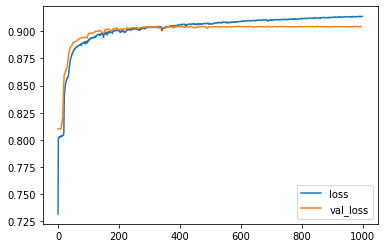

In [62]:
plt.plot(list(range(epoc)),np.array(train_hist.history['loss'])*(-1),label='loss')
plt.plot(list(range(0,epoc,5)),np.array(train_hist.history['val_loss'])*(-1),label='val_loss')
plt.legend(['loss', 'val_loss'])

In [63]:
train_hist.history

{'loss': [-0.7319687008857727,
  -0.8002187013626099,
  -0.8020742535591125,
  -0.8021090030670166,
  -0.802747905254364,
  -0.8031164407730103,
  -0.8026608824729919,
  -0.8030943274497986,
  -0.802776575088501,
  -0.8033462166786194,
  -0.8038328886032104,
  -0.8036477565765381,
  -0.8035223484039307,
  -0.8040755391120911,
  -0.8037158250808716,
  -0.8037220239639282,
  -0.8041132092475891,
  -0.8042351007461548,
  -0.8044206500053406,
  -0.8071003556251526,
  -0.8303919434547424,
  -0.8423891663551331,
  -0.8445953130722046,
  -0.84779292345047,
  -0.8506074547767639,
  -0.8521968722343445,
  -0.8533551692962646,
  -0.8543387055397034,
  -0.8552384972572327,
  -0.8561765551567078,
  -0.8571743369102478,
  -0.856856107711792,
  -0.8573840260505676,
  -0.8578569293022156,
  -0.8585739731788635,
  -0.86161208152771,
  -0.8642503023147583,
  -0.8665028214454651,
  -0.8686960339546204,
  -0.8709852695465088,
  -0.872967541217804,
  -0.8739193081855774,
  -0.8750817775726318,
  -0.876093

### Training the whole dataset for submitting results

In [61]:
epoc = 700
train_hist = model.fit(training_generator, validation_data=validation_generator, batch_size=b_size,epochs=epoc, verbose=1,validation_freq=5)

Epoch 1/700
15/15 [==============================] - 3s 171ms/step - loss: -0.7368
Epoch 2/700
15/15 [==============================] - 3s 169ms/step - loss: -0.8001
Epoch 3/700
15/15 [==============================] - 3s 169ms/step - loss: -0.8026
Epoch 4/700
15/15 [==============================] - 3s 170ms/step - loss: -0.8019
Epoch 5/700
15/15 [==============================] - 3s 185ms/step - loss: -0.8030 - val_loss: -0.8114
Epoch 6/700
15/15 [==============================] - 3s 179ms/step - loss: -0.8036
Epoch 7/700
15/15 [==============================] - 3s 177ms/step - loss: -0.8035
Epoch 8/700
15/15 [==============================] - 3s 180ms/step - loss: -0.8039
Epoch 9/700
15/15 [==============================] - 3s 184ms/step - loss: -0.8041
Epoch 10/700
15/15 [==============================] - 3s 183ms/step - loss: -0.8047 - val_loss: -0.8128
Epoch 11/700
15/15 [==============================] - 3s 177ms/step - loss: -0.8121
Epoch 12/700
15/15 [=========================

15/15 [==============================] - 3s 173ms/step - loss: -0.8990
Epoch 187/700
15/15 [==============================] - 3s 183ms/step - loss: -0.8994
Epoch 188/700
15/15 [==============================] - 3s 181ms/step - loss: -0.8993
Epoch 189/700
15/15 [==============================] - 3s 178ms/step - loss: -0.8992
Epoch 190/700
15/15 [==============================] - 3s 183ms/step - loss: -0.9002 - val_loss: -0.9029
Epoch 191/700
15/15 [==============================] - 3s 183ms/step - loss: -0.9004
Epoch 192/700
15/15 [==============================] - 3s 180ms/step - loss: -0.9003
Epoch 193/700
15/15 [==============================] - 3s 182ms/step - loss: -0.9001
Epoch 194/700
15/15 [==============================] - 3s 175ms/step - loss: -0.9004
Epoch 195/700
15/15 [==============================] - 3s 185ms/step - loss: -0.9005 - val_loss: -0.9031
Epoch 196/700
15/15 [==============================] - 3s 176ms/step - loss: -0.9009
Epoch 197/700
15/15 [==================

15/15 [==============================] - 3s 178ms/step - loss: -0.9048 - val_loss: -0.9043
Epoch 371/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9052
Epoch 372/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9055
Epoch 373/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9056
Epoch 374/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9057
Epoch 375/700
15/15 [==============================] - 3s 177ms/step - loss: -0.9055 - val_loss: -0.9044
Epoch 376/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9058
Epoch 377/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9057
Epoch 378/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9054
Epoch 379/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9057
Epoch 380/700
15/15 [==============================] - 3s 177ms/step - loss: -0.9057 - val_loss: -0.9040
Epoch 381/700
15/15

15/15 [==============================] - 3s 181ms/step - loss: -0.9073
Epoch 463/700
15/15 [==============================] - 3s 176ms/step - loss: -0.9074
Epoch 464/700
15/15 [==============================] - 3s 173ms/step - loss: -0.9074
Epoch 465/700
15/15 [==============================] - 3s 179ms/step - loss: -0.9076 - val_loss: -0.9045
Epoch 466/700
15/15 [==============================] - 3s 172ms/step - loss: -0.9077
Epoch 467/700
15/15 [==============================] - 3s 173ms/step - loss: -0.9076
Epoch 468/700
15/15 [==============================] - 3s 173ms/step - loss: -0.9077
Epoch 469/700
15/15 [==============================] - 3s 174ms/step - loss: -0.9076
Epoch 470/700
15/15 [==============================] - 3s 181ms/step - loss: -0.9077 - val_loss: -0.9039
Epoch 471/700
15/15 [==============================] - 3s 171ms/step - loss: -0.9076
Epoch 472/700
15/15 [==============================] - 3s 171ms/step - loss: -0.9077
Epoch 473/700
15/15 [==================

15/15 [==============================] - 3s 170ms/step - loss: -0.9105
Epoch 647/700
15/15 [==============================] - 3s 172ms/step - loss: -0.9099
Epoch 648/700
15/15 [==============================] - 3s 171ms/step - loss: -0.9097
Epoch 649/700
15/15 [==============================] - 3s 170ms/step - loss: -0.9099
Epoch 650/700
15/15 [==============================] - 3s 188ms/step - loss: -0.9097 - val_loss: -0.9039
Epoch 651/700
15/15 [==============================] - 3s 177ms/step - loss: -0.9101
Epoch 652/700
15/15 [==============================] - 3s 175ms/step - loss: -0.9103
Epoch 653/700
15/15 [==============================] - 3s 174ms/step - loss: -0.9104
Epoch 654/700
15/15 [==============================] - 3s 175ms/step - loss: -0.9101
Epoch 655/700
15/15 [==============================] - 3s 182ms/step - loss: -0.9104 - val_loss: -0.9042
Epoch 656/700
15/15 [==============================] - 3s 175ms/step - loss: -0.9105
Epoch 657/700
15/15 [==================

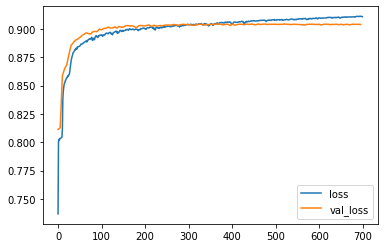

In [62]:
plt.plot(list(range(epoc)),np.array(train_hist.history['loss'])*(-1),label='loss')
plt.plot(list(range(0,epoc,5)),np.array(train_hist.history['val_loss'])*(-1),label='val_loss')
plt.legend(['loss', 'val_loss'])

In [63]:
train_hist.history

{'loss': [-0.7367607355117798,
  -0.8001192212104797,
  -0.8025668263435364,
  -0.801935613155365,
  -0.8029542565345764,
  -0.8035606741905212,
  -0.8035289645195007,
  -0.8038690090179443,
  -0.8041219115257263,
  -0.8047205805778503,
  -0.8120647668838501,
  -0.838061511516571,
  -0.8448390960693359,
  -0.8484242558479309,
  -0.8509435653686523,
  -0.8523496985435486,
  -0.8529779314994812,
  -0.854690670967102,
  -0.8550135493278503,
  -0.8564865589141846,
  -0.8568710088729858,
  -0.8570091724395752,
  -0.8585063219070435,
  -0.8580782413482666,
  -0.8588749766349792,
  -0.8597640991210938,
  -0.8599523305892944,
  -0.8629052042961121,
  -0.8662265539169312,
  -0.8688338398933411,
  -0.8718279004096985,
  -0.8736007213592529,
  -0.8754385113716125,
  -0.8766252994537354,
  -0.8783309459686279,
  -0.8792921900749207,
  -0.8795467615127563,
  -0.8804367184638977,
  -0.8811635971069336,
  -0.8818959593772888,
  -0.8817713260650635,
  -0.8828993439674377,
  -0.8829236626625061,
  -0.8

In [64]:
# del model
gc.collect()
K.clear_session()


In [64]:
cite_train_x_gen = MultiomeSequence_test(cite_train_x_raw, batch_size=4)
train_pred_y = model.predict(cite_train_x_gen)

In [65]:
train_pred_y.shape

(70988, 140)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa319537f60>]],
      dtype=object)

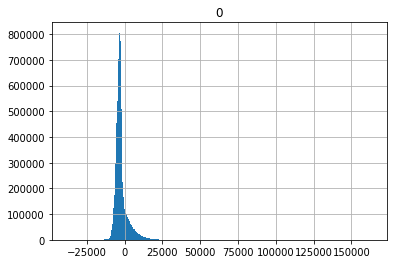

In [66]:
pd.DataFrame(train_pred_y.reshape(-1)).hist(bins=500)
# plt.xlim(-5,20)

(-5, 20)

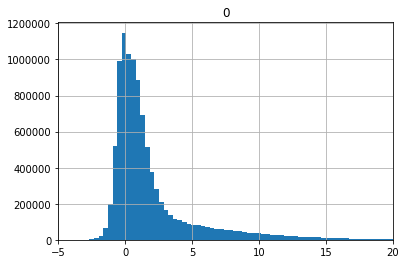

In [67]:
pd.DataFrame(cite_train_y_raw.reshape(-1)).hist(bins=500)
plt.xlim(-5,20)

In [68]:
CorrelationLoss_new()(train_pred_y, cite_train_y_raw)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.92092294>

In [69]:
CorrelationLoss_pure()(train_pred_y, cite_train_y_raw)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.92092294>

### So we have shown that the new loss function is correct.

# Predicting

In [70]:
cite_test_df = pd.read_hdf(FP_CITE_TEST_INPUTS)

In [71]:
cite_test_df = cite_test_df.iloc[:,use_idx].merge(cell_df, how='left',left_on='cell_id', right_on='cell_id').set_index('cell_id')

In [72]:
cite_test_x = cite_test_df.values

In [73]:
cite_test_x.shape

(48663, 4653)

In [74]:
cite_test_x_gen = MultiomeSequence_test(cite_test_x, batch_size=9)

In [75]:
test_pred = model.predict(cite_test_x_gen)

In [76]:
test_pred.shape

(48663, 140)

In [77]:
test_pred

array([[ -4271.203 ,  -4210.2764,  -3758.753 , ...,  -4077.804 ,
         -1694.7556,  -2413.4585],
       [ -4218.5728,  -4120.6016,  -3710.4563, ...,  -3970.3408,
         -1299.9246,  -2303.7773],
       [ -4591.541 ,  -4144.7144,  -3565.0535, ...,  -4465.79  ,
          4133.445 ,  -1915.9962],
       ...,
       [-17548.043 ,  -9606.482 , -12684.673 , ..., -17170.297 ,
        -14676.474 ,  -4627.8657],
       [ -4588.837 ,  -3941.253 ,  -3265.6584, ...,  -4249.654 ,
          4445.039 ,   2111.7214],
       [ -4576.579 ,  -3817.692 ,  -3051.5183, ...,  -4219.88  ,
          6376.879 ,   2925.87  ]], dtype=float32)

In [78]:
# test_pred = test_pred/10000

In [79]:
gc.collect()

36294

In [80]:
submission_prev = pd.read_csv('submission 804 NN.csv')['target']

In [81]:
submission_prev

0           9.460453e-02
1          -1.623624e-01
2          -4.053319e-01
3          -3.025821e-01
4           1.114355e+00
                ...     
65744175    9.840503e+09
65744176    0.000000e+00
65744177    0.000000e+00
65744178    1.860109e+09
65744179    9.638013e+09
Name: target, Length: 65744180, dtype: float64

In [82]:
submission_prev = submission_prev.astype('float32')

In [83]:
submission_prev[:len(test_pred.ravel())] = test_pred.ravel()

In [84]:
submission_prev

0          -4.271203e+03
1          -4.210276e+03
2          -3.758753e+03
3           1.062093e+03
4           2.893177e+03
                ...     
65744175    9.840503e+09
65744176    0.000000e+00
65744177    0.000000e+00
65744178    1.860109e+09
65744179    9.638013e+09
Name: target, Length: 65744180, dtype: float32

In [85]:
submission_prev.index.name="row_id"

In [86]:
submission_prev

row_id
0          -4.271203e+03
1          -4.210276e+03
2          -3.758753e+03
3           1.062093e+03
4           2.893177e+03
                ...     
65744175    9.840503e+09
65744176    0.000000e+00
65744177    0.000000e+00
65744178    1.860109e+09
65744179    9.638013e+09
Name: target, Length: 65744180, dtype: float32

In [87]:
submission_prev.to_csv("submission.csv")